# Методы оптимизации для решения прикладных задач: обзор

## Типы задач

- Дискретные
- Выпуклые
- Невыпуклые, но с некоторой структурой

## Матричные разложения

Представление матрицы $X$ в виде произведения $U$ и $V$.

**Теорема**
Любая матрица может быть представлена в виде 

SVD разложения

$$ X = U\Sigma V^* $$

- SVD даёт наилучшую аппроксимацию данной матрицы заданного ранга

### Приложение 1: тематическое моделирование и латентный семантический поиск

- Дан набор документов
- Необходимо разбить его на темы
- Модель мешка слов
- Для обеих задач нужно некоторое вложение документов в $\mathbb{R}^n$

### Модель мешка слов ("bag-of-words")

- Документ – это набор слов, порядок которых неважен
- Тема – это набор слов, наиболее характерных для неё

### Матрица документов-слов $A$

- Матрица размера $N_{docs} \times N_{terms}$
- Чем её заполнить?

### Возможные варианты

- Элемент $(i, j)$ – число вхождений слова $j$ в документ $i$
- Элемент $(i, j)$ - tf-idf для слова $j$ и документа $i$

Tf-Idf – произведение 

- tf = частота встречаемости слова в документе и 

- idf = $\log \frac{|D|}{|\{ d \in D \mid t \in D \}|}$, то есть логарифм отношения числа всех документов к числу документов, в которых есть слово, для которого вычисляется tf-idf. 

**Q:** какими свойствами будет обладать матрица $A$?

## Как из SVD получить требуемое вложение?

- Пусть дана матрица $A$
- Для получения вложений в $\mathbb{R}^n$ вычислим SVD для некоторого ранга $d$: $A = U\Sigma V^*$
- Матрица $U$ размера $N_{docs} \times d$, то есть каждый документ описывается некоторым вектором в $\mathbb{R}^d$
- Матрица $V$ размера $N_{terms} \times d$, то есть каждое слово также описывается некоторым вектором в $\mathbb{R}^d$ 

## Другая интерпретация

- Если ранг $d$ – это число тем в коллекции документов, то получаем некоторое распределение слов по темам и документов по темам
- Можно получить самые релевантные слова для каждой темы и самые характерные документы
- Также эти вложения можно использовать как входные данные для более продвинутых алгоритмов кластеризации/классификации

### Давайте посмотрим, как это всё работает!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spsplin
import scipy.sparse as spsp

### Загрузим данные

In [2]:
documents = []
with open("./test_articles.txt","r") as fin:
    for line in fin.readlines():
        text = line.strip()
        documents.append(text)
print("Total number of Documents:",len(documents))

Total number of Documents: 4551


### Пример документа

In [109]:
documents[119]

'Manchester United v Tottenham Hotspur: match preview The mood at Manchester United is one of frustration mixed with confidence that very soon everything will begin to click and performance will match result. Tottenham Hotspur are six points ahead of José Mourinho’s side in fifth place and given Mauricio Pochettino was of interest to United before hiring the Portuguese each man may have a little extra motivation to deliver three points. Jamie Jackson Kick-off 2.15pm Venue Old Trafford Last season Man Utd 1 Tottenham 0 Live Sky Sports 1 Referee Robert Madley This season G10, Y49, R0, 4.9 cards per game Odds H 5-4 A 3-1 D 5-2 Manchester Utd Subs from Romero, Johnstone, Depay, Lingard, Fosu-Mensah, Tuanzebe, Schneiderlin, Young, Blind, Fellaini, Schweinsteiger, Rashford, Mata, Rojo, Rooney Doubtful None Injured Shaw (match fitness, 14 Dec), Smalling (toe, 17 Dec) Suspended None Form LDWDDD Discipline Y34 R1 Leading scorer Ibrahimovic 8 Tottenham Hotspur Subs from Vorm, López, Trippier, Da

### Необходимый препроцессинг текста

In [3]:
news_df = pd.DataFrame({'document': documents})

# removing everything except alphabets`
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")

# removing short words
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print(stop_words[:10])
# tokenization
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

news_df['clean_doc'] = detokenized_doc

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


### До vs. после

In [6]:
news_df.head()

,document,clean_doc
0,Barclays' defiance of US fines has merit Barcl...,barclays defiance fines merit barclays disgrac...
1,How big is Hillary Clinton's lead in the presi...,hillary clinton lead presidential race depends...
2,Zika’s greatest ally is human intransigence Th...,zika greatest ally human intransigence revenge...
3,Fight for the right: Cruz and Rubio spar in Ne...,fight right cruz rubio spar nevada trump chall...
4,Voting day: America finally goes the polls Can...,voting america finally goes polls candidates s...


### Построим матрицу $A$

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # keep top 1000 terms 
)

# vectorizer = CountVectorizer(stop_words="english", max_features=100)

X = vectorizer.fit_transform(news_df['clean_doc'])

X.shape

(4551, 1000)

In [8]:
X, X.nnz

(<4551x1000 sparse matrix of type '<class 'numpy.float64'>'
 	with 497895 stored elements in Compressed Sparse Row format>, 497895)

### Специальное SVD для разреженных матриц!

- Для плотных матриц есть функция ```np.linalg.svd```, которая возвращает факторы $U$, $\Sigma$ и $V$ для точного восстановления матрицы

In [9]:
import numpy as np
n = 10
test_x = np.random.randn(n, n)
u, s, v = np.linalg.svd(test_x)
print(np.linalg.norm(test_x - u @ (s[:, np.newaxis] * v), 2))

7.259708186878224e-15


- Однако у нас матрица разреженная!
- Для таких матриц обычно нужны не все сингулярные числа и вектора, а только первые $k \ll n$
- Для этого используются специальные алгоритмы!
- Пока же просто вызовём функцию из модуля ```scipy.sparse.linalg``` 

In [10]:
u, sigma, v = spsplin.svds(X.asfptype(), k=7)

### Посмотрим на убывание сингулярных чисел

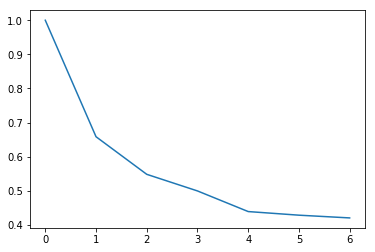

In [11]:
plt.plot(sigma[::-1]/sigma[-1])

In [12]:
terms = vectorizer.get_feature_names()
print(len(terms))
print(terms[:10])

1000
['ability', 'able', 'abortion', 'absolutely', 'abuse', 'accept', 'access', 'according', 'account', 'accounts']


### Темы и "главные" слова для них

In [13]:
for i, comp in enumerate(v):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print("Word: {}, score: {}".format(t[0], t[1]))

Topic 0: 
Word: health, score: 0.40862330747376874
Word: mental, score: 0.22240931303128725
Word: care, score: 0.22169596123074495
Word: patients, score: 0.20331924410163693
Word: people, score: 0.15992102366539657
Word: doctors, score: 0.14215598718119746
Word: hospital, score: 0.1325782197669305
Word: social, score: 0.11089865675449893
Word: says, score: 0.10809725354632962
Word: children, score: 0.10648923164782348
Topic 1: 
Word: film, score: 0.48038693031676405
Word: films, score: 0.12755665655401316
Word: movie, score: 0.1249785732242679
Word: director, score: 0.0846370876408235
Word: hollywood, score: 0.07996289850111983
Word: women, score: 0.07789731411556998
Word: health, score: 0.07000273851282515
Word: actor, score: 0.06921527165008458
Word: said, score: 0.055688664842670044
Word: drama, score: 0.055478115562781365
Topic 2: 
Word: bank, score: 0.4979364782266319
Word: banks, score: 0.23519917763522913
Word: film, score: 0.2138460671932756
Word: banking, score: 0.162724779306

### Темы и "главные" документы для них

In [14]:
top_docs = np.argmax(u, axis=0)
print(top_docs)
for i, j in enumerate(top_docs):
    print("Topic {}".format(i))
    print(documents[j])
    print(" ")

[3116 2806 2414 2806 1057  464  658]
Topic 0
Public Service Awards 2016 health and wellbeing winner: Derventio Housing Trust “Quite often people are in hospital and they’ve got nothing: no food, no clothes, no toiletries,” says Kate Gillespie, Derventio Housing Trust’s strategic lead for its Healthy Futures initiative. “We get all that sorted out, so people at least have a bit of dignity when they are discharged.” That’s just the start of the scheme’s work with homeless people due to leave hospital. Many have multiple, complex needs, such as mental health problems and addictions, and are trapped in a vicious cycle of ongoing health issues and repeat admissions. Over a 12-week period, staff work intensively to find housing for patients, settle them into their new homes and help them live independently – while making better use of primary care, rather than relying disproportionately on acute services. “Sometimes it’s because they don’t manage their health, so they actually get ill enough

### Найдём по данному запросу ближайший документ

In [15]:
new_request_original = '''There were four minutes remaining and none of the Newcastle United fans had left. 
Even with their team a man down and four goals down, they stayed. 
Even with another reminder of how their well-intentioned manager, Steve Bruce, 
struggles to build on the good work of Rafa Benítez, 
they kept standing there, kept singing, defying the rain and the pain.'''

# removing everything except alphabets`
new_request = new_request_original.replace("[^a-zA-Z#]", " ")

# removing short words
new_request = ' '.join([w for w in new_request.split() if len(w)>3])

# make all text lowercase
new_request = new_request.lower()


# tokenization
tokenized_doc = new_request.split()

# remove stop-words
tokenized_doc = [item for item in tokenized_doc if item not in stop_words]

# de-tokenization
detokenized_request = ' '.join(tokenized_doc)

y = vectorizer.transform([detokenized_request]).toarray().T
y.shape, v.shape

((1000, 1), (7, 1000))

In [17]:
score = u @ (sigma[:, np.newaxis] * v.dot(y))
print(score.shape)
idx_best = np.argmax(score)
print(documents[idx_best])

(4551, 1)
Premier League: 10 things to look out for this weekend 1) Start of a tough run for the Hammers On the last day of the 2006-07 season Manchester United, who had won the title five days earlier, fielded a weakened side – Cristiano Ronaldo, Ryan Giggs, Paul Scholes, Rio Ferdinand and Nemanja Vidic were all left out of the starting XI – at Old Trafford against a West Ham team who needed at least a point to avoid relegation. Carlos Tevez, who was to join United a few weeks later, scored the only goal on the stroke of half-time. “They couldn’t have come to Old Trafford on a better day,” said Sir Alex Ferguson after the game. “We had already won the league and the edge was off our game.” There was also a 1-0 win in December 2001, against a wretchedly out-of-form United side that were completing a memorably horrific run of five defeats in seven league games. Those two games are the Hammers’ only highlights in a miserable run of top-flight visits to Old Trafford that now extends over 

## Приложение 2: рекомендательные системы

### Что дано?

- Матрица пользователь-продукт
- Элементы матрицы – рейтинги, если есть
- Неполное заполнение

## Как использовать SVD?

- Оригинальная работа [*Performance of recommender algorithms on top-n recommendation tasks*](https://dl.acm.org/citation.cfm?id=1864721), Cremonesi, P., Koren, Y., and Turrin, R
- Построим вложение пользователей и продуктов в некоторое подпространство $\mathbb{R}^n$
- Для известных предпочтений найдём наиболее близкие продукты в этом подпространстве
- Как это вычислительно сделать?

### Датасет Movielens с рейтингами фильмов

In [18]:
movies = pd.read_csv('movies.gz', index_col='movieid', header=0, encoding='unicode-escape')[['movienm', 'genreid']]
ratings = pd.read_csv('ratings.gz', header=0)

### Пример записей

In [19]:
movies.head()

,movienm,genreid
movieid,,
1,Toy Story (1995),"Animation, Children's, Comedy"
2,Jumanji (1995),"Adventure, Children's, Fantasy"
3,Grumpier Old Men (1995),"Comedy, Romance"
4,Waiting to Exhale (1995),"Comedy, Drama"
5,Father of the Bride Part II (1995),Comedy


In [20]:
ratings.head()

,userid,movieid,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [21]:
ratings[['userid', 'movieid']].apply(pd.Series.nunique)

userid     6040
movieid    3706
dtype: int64

### Зададим список предпочтений

In [37]:
best_movies = "titanic|dracula"
target_movies = movies.loc[movies.movienm.str.contains(best_movies, flags=2)]
target_movies

,movienm,genreid
movieid,,
12,Dracula: Dead and Loving It (1995),"Comedy, Horror"
1329,Blood For Dracula (Andy Warhol's Dracula) (1974),Horror
1339,Bram Stoker's Dracula (1992),"Horror, Romance"
1721,Titanic (1997),"Drama, Romance"
2157,"Chambermaid on the Titanic, The (1998)",Romance
2644,Dracula (1931),Horror
2645,Dracula (1958),Horror
2646,House of Dracula (1945),Horror
2653,Son of Dracula (1943),Horror


### Выделим индексы выбранных фильмов

In [38]:
favorite_movies_ids = target_movies.index
print(favorite_movies_ids)

Int64Index([12, 1329, 1339, 1721, 2157, 2644, 2645, 2646, 2653, 3403, 3404], dtype='int64', name='movieid')


### Создадим матрицу с рейтингами 

In [39]:
data_matrix = spsp.csr_matrix((ratings.rating.values.astype('f8'), 
                               (ratings.userid.values, ratings.movieid.values)))
print(data_matrix.shape)

(6041, 3953)


### Вычислим SVD

In [40]:
rank = 30
_, S, Vt = spsplin.svds(data_matrix, k=rank, return_singular_vectors='vh')

### Посмотрим на убывание сингулярных чисел

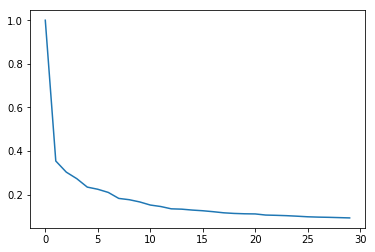

In [31]:
plt.plot(S[::-1] / S[-1])

### Получим корреляции

In [41]:
print(Vt[:, favorite_movies_ids].shape)
correlation = Vt.T @ Vt[:, favorite_movies_ids]
print(correlation.shape)
score = correlation.sum(axis=1)
print(score.shape)
# movies.loc[np.argsort(-Vt.T @ Vt[:, favorite_movies_ids].sum(axis=1))[:15]] # assuming binary preference vector

(30, 11)
(3953, 11)
(3953,)


### Вычислим итоговые рекомендации

In [42]:
top_n = 10
print(np.sort(score)[::-1][:top_n])
movies.loc[np.argsort(-score)[:top_n]]

[0.06773427 0.062023   0.05474846 0.05442924 0.05396276 0.05239618
 0.05205923 0.0506732  0.0498725  0.04886421]


,movienm,genreid
movieid,,
1721,Titanic (1997),"Drama, Romance"
1997,"Exorcist, The (1973)",Horror
356,Forrest Gump (1994),"Comedy, Romance, War"
1258,"Shining, The (1980)",Horror
253,Interview with the Vampire (1994),"Drama, Horror"
1982,Halloween (1978),Horror
3499,Misery (1990),Horror
1345,Carrie (1976),Horror
1339,Bram Stoker's Dracula (1992),"Horror, Romance"


### Cумма функций
    
$$ f(x, w) = \sum_{i=1}^m f(x_i, w) $$

- Обычно $m$ очень большое
- Но хранить градиенты всё ещё можно

### Классические формулировки задач машинного обучения

- Регрессия

$$\| f(x, w) - y\|^2_2 \to \min_w $$

- Классификация

$$\sum_{i=1}^m \ell(w \mid x_i, y_i) \to \min_w $$

### Когда нужно не совсем решение

- Обобщающая способность и переобучение
- Специальный вид функций потерь и моделей, минимизация которых даёт лучшую обобщаемость

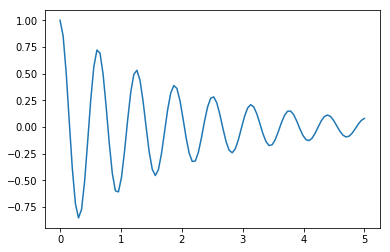

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

w = np.array([1, -0.5, 10, 0])
def f(x, w=w):
    return w[0] * torch.exp(x * w[1]) * torch.cos(w[2] * x + w[3])

num_points = 100
x_range = torch.linspace(0, 5, steps=num_points)
plt.plot(x_range.numpy(), f(x_range).numpy())

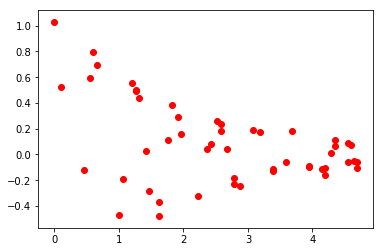

In [9]:
num_samples = 50
x_samples = torch.tensor(np.random.choice(x_range, size=num_samples))
y_samples = f(x_samples) + 0.05 * torch.randn(num_samples)
plt.scatter(x_samples.numpy(), y_samples.numpy(), c="red")

In [18]:
import torch
import torchvision
from torchvision import datasets

loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_samples, y_samples), batch_size = 50)

# w0 = torch.randn(4)
# w0.requires_grad_(True)
w0 = torch.tensor([0, -0.5, 10, 0.1], requires_grad=True)

optimizer = torch.optim.Adam([w0], lr=1e-3)
num_epoch = 1000

for i in range(num_epoch):
    for xi, yi in loader:
        optimizer.zero_grad()
        pred = f(xi, w0)
        loss = (pred - yi) @ (pred - yi)
        loss.backward()
        optimizer.step()
    print(loss.item())

5.438385486602783
5.428042411804199
5.417688369750977
5.407319068908691
5.396934986114502
5.386532783508301
5.376114368438721
5.3656768798828125
5.355220794677734
5.344744682312012
5.334249973297119
5.323734283447266
5.313197612762451
5.302639961242676
5.292059898376465
5.281457901000977
5.270833969116211
5.260185718536377
5.249515533447266
5.238821029663086
5.228102684020996
5.217360496520996
5.206594944000244
5.195803642272949
5.184988021850586
5.174147605895996
5.1632819175720215
5.152392387390137
5.141476631164551
5.130536079406738
5.119570255279541
5.108579635620117
5.097562789916992
5.086522102355957
5.075455188751221
5.064363479614258
5.05324649810791
5.042104721069336
5.030938148498535
5.01974630355835
5.008530139923096
4.997288703918457
4.986021995544434
4.9747314453125
4.963415622711182
4.952075481414795
4.94071102142334
4.929320335388184
4.917905807495117
4.906465530395508
4.895000457763672
4.883509159088135
4.871993064880371
4.860450744628906
4.848881721496582
4.83728647232

0.9523144960403442
0.9506511688232422
0.9489903450012207
0.9473330974578857
0.9456790089607239
0.944027304649353
0.9423787593841553
0.9407334327697754
0.9390905499458313
0.9374513030052185
0.935814380645752
0.934180498123169
0.9325498342514038
0.9309214353561401
0.9292970895767212
0.9276752471923828
0.9260563254356384
0.9244400858879089
0.9228270053863525
0.9212162494659424
0.9196093678474426
0.9180043935775757
0.9164031744003296
0.9148041009902954
0.9132083654403687
0.9116155505180359
0.910025417804718
0.9084386825561523
0.9068537950515747
0.9052727222442627
0.9036937355995178
0.902118444442749
0.9005452394485474
0.8989750146865845
0.8974082469940186
0.8958435654640198
0.8942821621894836
0.8927236795425415
0.8911678194999695
0.8896145224571228
0.8880646824836731
0.8865171074867249
0.8849722743034363
0.8834308385848999
0.8818914890289307
0.880355715751648
0.8788221478462219
0.8772915601730347
0.8757634162902832
0.874238133430481
0.8727161884307861
0.8711962699890137
0.8696795105934143


In [19]:
print(w)
print(w0.detach().numpy())
y_pred = f(x_range, w0.detach())


[ 1.  -0.5 10.   0. ]
[ 0.63016695 -0.28623897  9.975043   -0.01195789]


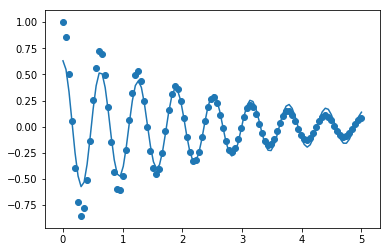

In [20]:
plt.plot(x_range.numpy(), y_pred.numpy())
plt.scatter(x_range.numpy(), f(x_range).numpy())

### Стохастические оценки
    
$$ f(x) = \mathbb{E}_{\xi} g(x, \xi)$$

### Оценка следа матрицы (a.k.a Hutchinson trace estimator)

- Дана квадратная матрица $X$ или функция, которая умножает её на вектор
- Рассмотрим 

$$tr(X) = tr(XI) = \mathbb{E} [tr(Xzz^{\top})] = \mathbb{E} [z^{\top}Xz],$$

для случайных величин $z$ с единичной ковариационной матрицей.

Примеры 

- $\mathcal{N}(0, I)$
- Распределение Радемахера

## Точность формализации

- Внешние и внутренние критерии
- Целевые прокси-функции
- Аппроксимация требований реального мира
    - функции потерь для классификации
    - рекомендательные системы
    - тематическое моделирование

## Доступная информация

- Можно ли вычислить градиент?
- Можно ли хранить градиент?
- Можно ли хранить гессиан?
- Нужно ли хранить гессиан?
- Какая дополнительная информация о задаче доступна?

## Методы и их реализации

- Безградиентные
    - [Nevergrad](https://github.com/facebookresearch/nevergrad)
    - [Zoopt](https://github.com/eyounx/ZOOpt)
    - [Scipy](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#global-optimization)
    - [MATLAB toolboxes](https://www.mathworks.com/help/gads/)
- Методы первого порядка
    - точные: возможно вычислить и хранить точный градиент
    - стохастические: градиент можно хранить, но нельзя вычислить точно
- Методы первого порядка для простых ограничений
    - Вычисление проекции
    - Решение линейной задачи на допустимом множестве
- Методы внутренней точки
    - Коническая оптимизация и всё, что к ней сводится
    - Проекты [cvx](http://cvxr.com/cvx/), [cvxpy](https://www.cvxpy.org/index.html)

## Технические детали

- Модель чёрного ящика
- Эвристики и Байесовская оптимизация
- Автоматическое дифференцирование, теорема Баура-Штрассена
- Умножение гессиана на вектор - достаточно для методов второго порядка

In [21]:
import torch

n = 5
A = torch.randn((n, n), requires_grad=True)
b = torch.randn((n,))
x = torch.randn((n,), requires_grad=True)

f = 0.5 * x @ A @ x - b @ x
f.backward()
print(f)
print(f.item())

tensor(1.4746, grad_fn=<SubBackward0>)
1.474555253982544


In [22]:
manual_grad_x = 0.5 * (A + A.t()) @ x - b

print(manual_grad_x.data)
print(x.grad.data)

tensor([ 2.7857,  3.0105,  1.0885, -1.3457,  0.0904])
tensor([ 2.7857,  3.0105,  1.0885, -1.3457,  0.0904])


In [24]:
manual_grad_A = 0.5 * torch.ger(x, x)

# print(manual_grad_A.data)
# print(A.grad.data)
print(torch.norm(manual_grad_A.data - A.grad.data).item())

0.0


## Матричные функции

In [25]:
X = torch.rand(10, 10, requires_grad=True)
d = torch.det(X)
print(d.item())
d.backward()
autograd = X.grad.data
manual_grad = torch.inverse(X.detach()).t() * d.detach()
print(torch.norm(autograd - manual_grad))

0.02044147439301014
tensor(0.)


## Что нужно для вычисления матриц Якоби и гессианов?

In [35]:
x = torch.rand(10, requires_grad=True)
y = torch.zeros_like(x)
for i in range(10):
    y[i] = torch.sin(x[i])
    y[i].backward(retain_graph=True)
print(y[1].grad)

None


## Выводы

1. Задачи бывают разные и нужно уметь выделять в них то, что позволит их решить
2. Существует большое количество готовых пакетов для решения задач определённый классов
3. Более того, часто есть гарантии качества на решение
4. Распознать правильный метод для конкретной задачи - непростая задача!